# Product Categorization

### Initial Setup

In [2]:
%matplotlib inline

# basic libs
from time import time
from queue import PriorityQueue
import numpy as np
import pandas as pd

# data preprocessing
import missingno as msno

# graphics
import graphics as graph
import matplotlib.pyplot as plt
import seaborn as sns

# graphics preset
sns.set(color_codes=True)

# sample split
from sklearn.model_selection \
    import train_test_split, GridSearchCV, StratifiedShuffleSplit, ShuffleSplit

# text feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer
from stopwords import stop_words_pt

# classifiers
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# model manipulation
from sklearn.base import clone

# metrics
from sklearn.metrics import f1_score, make_scorer

# custom classifier
from HierarchicalClassifier import HierarchicalClassifier

### Sample Data Loading

In [3]:
# load data from csv file
try:
    original_data = pd.read_csv('products.csv') 
    print("{} samples, {} attributes each.".format(*original_data.shape))
except Exception as e: 
    print("Error loading sample data.", e)

42747 samples, 11 attributes each.


### Data Exploration and Preprocessing

In [4]:
# printing all feature names
print("Features: {}".format(list(original_data)))

Features: ['name', 'description', 'manufacturer', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8']


In [5]:
# checking the first rows
original_data.head()

name  \
0                Duracell - AAA Batteries (4-Pack)   
1  Duracell - AA 1.5V CopperTop Batteries (4-Pack)   
2                 Duracell - AA Batteries (8-Pack)   
3            Energizer - MAX Batteries AA (4-Pack)   
4                  Duracell - C Batteries (4-Pack)   

                                         description manufacturer  \
0  Compatible with select electronic devices; AAA...     Duracell   
1  Long-lasting energy; DURALOCK Power Preserve t...     Duracell   
2  Compatible with select electronic devices; AA ...     Duracell   
3  4-pack AA alkaline batteries; battery tester i...    Energizer   
4  Compatible with select electronic devices; C s...     Duracell   

                cat_1                cat_2       cat_3  \
0  Alkaline Batteries  Household Batteries  Housewares   
1  Alkaline Batteries  Household Batteries  Housewares   
2  Alkaline Batteries  Household Batteries  Housewares   
3  Alkaline Batteries  Household Batteries  Housewares   
4  Alkaline Batteries  Household Batteries  Housewares   

                         cat_4 cat_5 cat_6  cat_7  cat_8  
0  Connected Home & Housewares   NaN   NaN    NaN    NaN  
1  Connected Home & Housewares   NaN   NaN    NaN    NaN  
2  Connected Home & Housewares   NaN   NaN    NaN    NaN  
3  Connected Home & Housewares   NaN   NaN    NaN    NaN  
4  Connected Home & Housewares   NaN   NaN    NaN    NaN

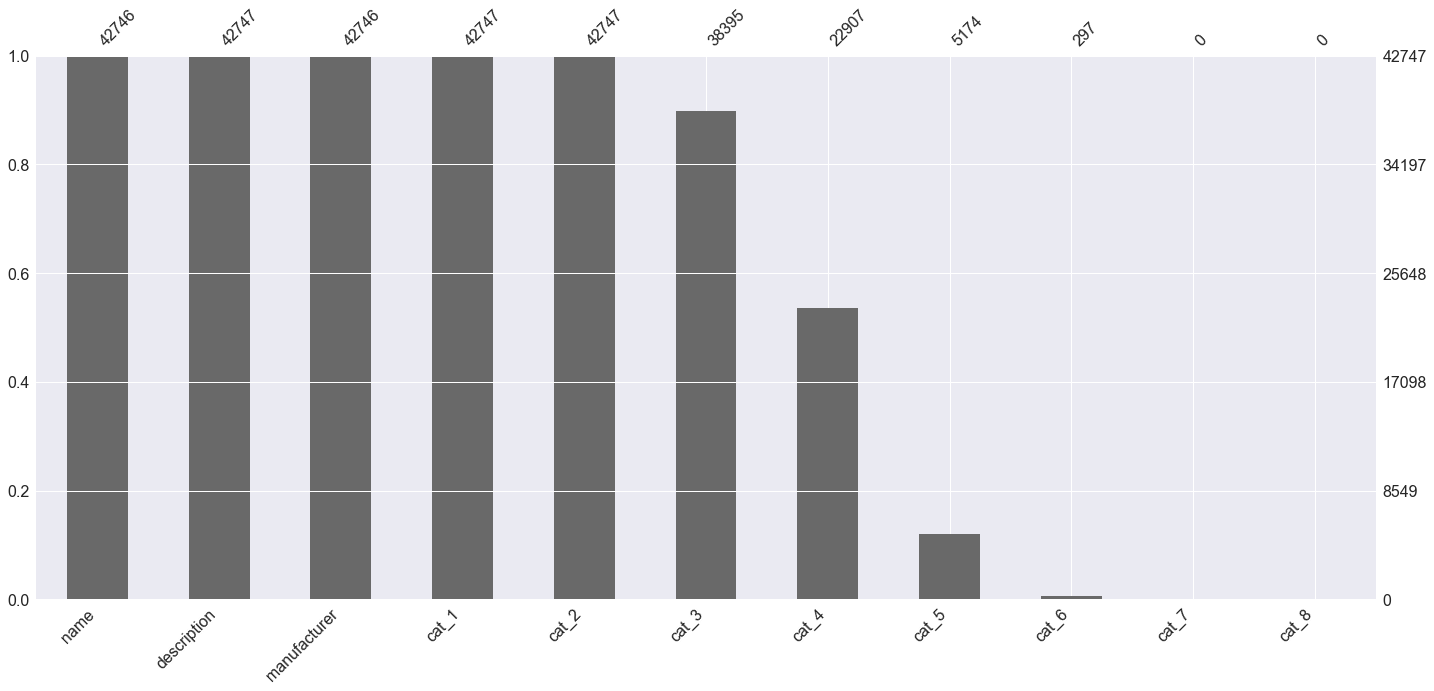

In [6]:
# looking for missing data
msno.bar(original_data)

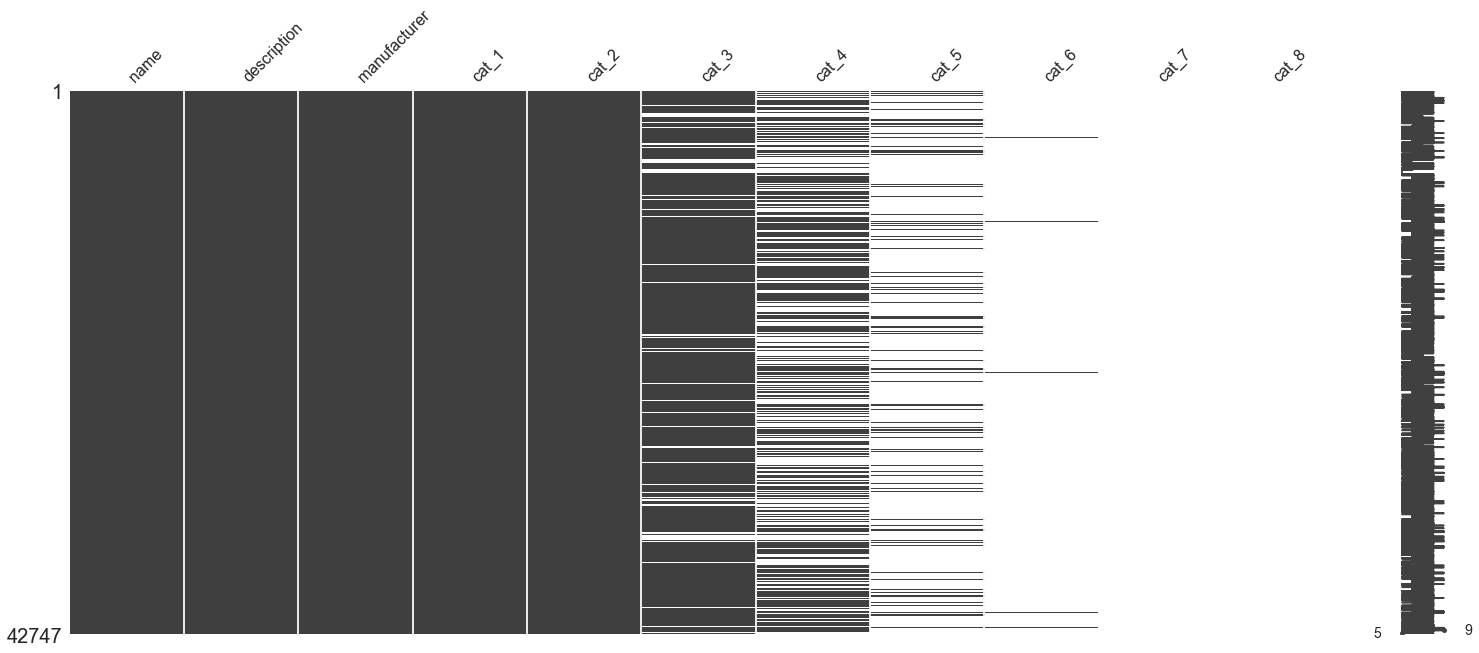

In [7]:
# looking for inconsistent missing data
msno.matrix(original_data)

In [8]:
# preserving original data
processed_data = original_data.copy()

In [9]:
# inverting category order, to be top -> down
def get_categories_top_down(row):
    categories = []
    for i in range(5, 0, -1):
        category = row['cat_' + str(i)]
        if type(category) is str and len(category) > 0:
            categories.append(category)
    # padding with NaN
    categories += [np.NaN] * (5 - len(categories))
    return pd.Series(categories)
     
processed_data[
    ['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5']] = \
    processed_data.apply(get_categories_top_down, axis=1)

In [10]:
# drop category levels with insignificant data
processed_data.drop(['cat_6', 'cat_7', 'cat_8'], axis=1, inplace=True)

In [11]:
# filling NaN category names with a generic value
general_category_name = "__general__"

processed_data.fillna({
    'cat_1':general_category_name, 
    'cat_2':general_category_name, 
    'cat_3':general_category_name,
    'cat_4':general_category_name,
    'cat_5':general_category_name,
    'cat_6':general_category_name}, 
    inplace=True)

In [12]:
# creating category paths
category_separator = "::"

processed_data['cat_path_1'] = processed_data['cat_1']
processed_data['cat_path_2'] = processed_data['cat_path_1'] + category_separator + processed_data['cat_2']
processed_data['cat_path_3'] = processed_data['cat_path_2'] + category_separator + processed_data['cat_3']
processed_data['cat_path_4'] = processed_data['cat_path_3'] + category_separator + processed_data['cat_4']
processed_data['cat_path_5'] = processed_data['cat_path_4'] + category_separator + processed_data['cat_5']

In [13]:
# checking product distribution per category
def product_distribution_per_category(df):
    value_counts = df['cat_path_5'].value_counts()
    value_counts_desc = value_counts.describe()

    print("""
    {:.0f} products
    {:.0f} categories
    Products per category:
        Mean:    {:.0f} (Std. Deviation: {:.0f})
        Minimum: {:.0f}
        25%:     {:.0f}
        50%:     {:.0f}
        75%:     {:.0f}
        Maximum: {:.0f}
    """.format(
        processed_data.shape[0],
        value_counts_desc['count'],
        value_counts_desc['mean'],
        value_counts_desc['std'],
        value_counts_desc['min'],
        value_counts_desc['25%'],
        value_counts_desc['50%'],
        value_counts_desc['75%'],
        value_counts_desc['max']
    ))

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set(ylabel='Frequency')
    sns.distplot(value_counts, bins=100, kde=False, ax=ax, color='red', axlabel='Products per Category')
    plt.show()


    42747 products
    1161 categories
    Products per category:
        Mean:    37 (Std. Deviation: 138)
        Minimum: 1
        25%:     3
        50%:     11
        75%:     34
        Maximum: 3578
    


C:\Users\rafael.zitto\AppData\Local\conda\conda\envs\Python3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


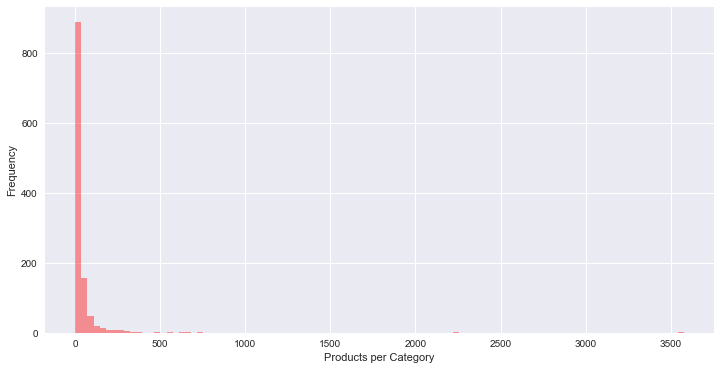

In [14]:
product_distribution_per_category(processed_data)

In [15]:
# prunning categories
def prunning_categories(df, minimum_quantity, maximum_quantity, column_name):
    
    initial_category_count = df[column_name].unique().shape[0]

    print("Products before prunning: {}".format(df.shape[0]))
    print("Categories before prunning: {}".format(initial_category_count))

    products_per_category = df[column_name].value_counts()
    
    # deleting products from small categories
    df = df[
        df[column_name].isin(
            products_per_category[products_per_category >= minimum_quantity].index
        )]
    
    # limiting products from large categories
    for large_category in products_per_category[products_per_category > maximum_quantity].index:
        large_category_df = df[df[column_name] == large_category]
        quantity_to_delete = products_per_category[large_category] - maximum_quantity
        to_delete_df = large_category_df.sample(n=quantity_to_delete, random_state=42)
        df = df[np.logical_not(df.index.isin(to_delete_df.index))]

    final_category_count = df[column_name].unique().shape[0]

    print("Products after prunning: {}".format(df.shape[0]))
    print("Categories after prunning: {}".format(final_category_count))
    print()
    
    return df

In [16]:
minimum_quantity_per_category = 50
maximum_quantity_per_category = 500

processed_data = prunning_categories(processed_data, minimum_quantity_per_category, maximum_quantity_per_category, 'cat_path_5') 

Products before prunning: 42747
Categories before prunning: 1161
Products after prunning: 25115
Categories after prunning: 197




    25115 products
    197 categories
    Products per category:
        Mean:    127 (Std. Deviation: 105)
        Minimum: 50
        25%:     62
        50%:     84
        75%:     152
        Maximum: 500
    


C:\Users\rafael.zitto\AppData\Local\conda\conda\envs\Python3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


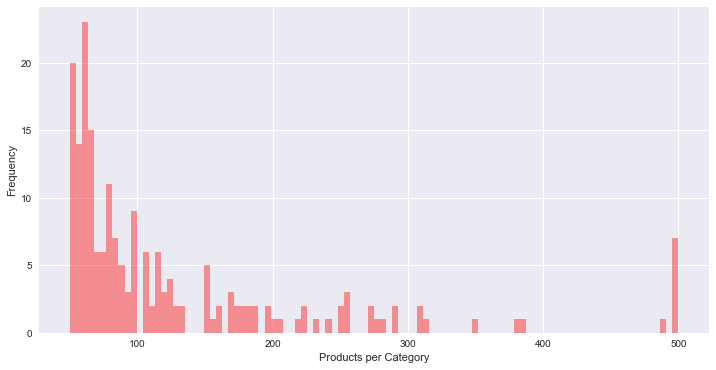

In [17]:
product_distribution_per_category(processed_data)

count    167.000000
mean       2.173653
std        2.091238
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       13.000000
dtype: float64


C:\Users\rafael.zitto\AppData\Local\conda\conda\envs\Python3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


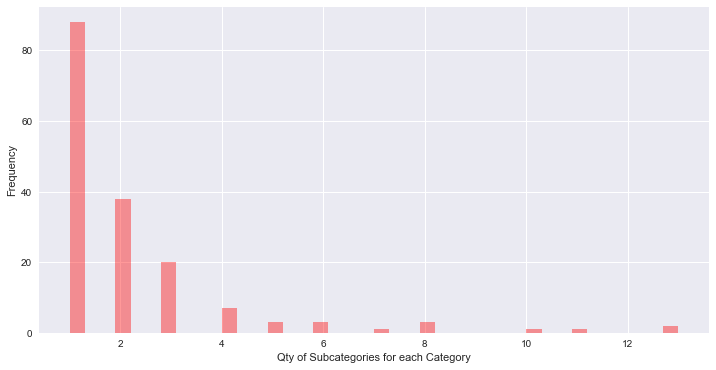

In [18]:
#checking quantity of subactegories for each category
sub_cat_1_count = processed_data[['cat_1']].agg({'cat_1': 'nunique'})
sub_cat_2_count = processed_data.loc[processed_data['cat_2'] != general_category_name].groupby(['cat_path_1']).agg({'cat_path_2': 'nunique'})
sub_cat_3_count = processed_data.loc[processed_data['cat_3'] != general_category_name].groupby(['cat_path_2']).agg({'cat_path_3': 'nunique'})
sub_cat_4_count = processed_data.loc[processed_data['cat_4'] != general_category_name].groupby(['cat_path_3']).agg({'cat_path_4': 'nunique'})
sub_cat_5_count = processed_data.loc[processed_data['cat_5'] != general_category_name].groupby(['cat_path_4']).agg({'cat_path_5': 'nunique'})

sub_cat_count = pd.concat([
    sub_cat_1_count, 
    sub_cat_2_count['cat_path_2'],
    sub_cat_3_count['cat_path_3'],
    sub_cat_4_count['cat_path_4'],
    sub_cat_5_count['cat_path_5']
    ], ignore_index=True)

print(sub_cat_count.describe())

fig, ax = plt.subplots(figsize=(12, 6))
ax.set(ylabel='Frequency')
sns.distplot(sub_cat_count, bins=40, kde=False, ax=ax, color='red', axlabel='Qty of Subcategories for each Category')
plt.show()

Vocabulary Length for name: 11045
Vocabulary Length for description: 15520
Vocabulary Length for manufacturer: 1489


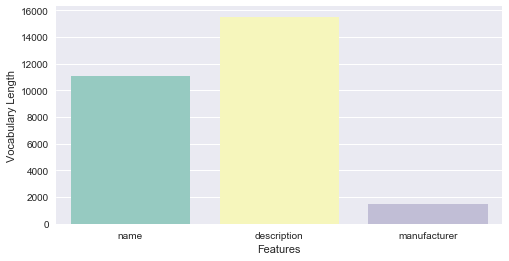

In [19]:
# checking vocabulary length for each text feature
vocabulary_length_by_feature = []

features = ['name', 'description', 'manufacturer']

for feature in features:
    tfidf_vect = TfidfVectorizer(encoding='utf-8', analyzer='word', lowercase=True, stop_words='english')
    tfidf_vect.fit(processed_data[processed_data[feature].notnull()][feature])
    vocabulary_length = len(tfidf_vect.get_feature_names())
    vocabulary_length_by_feature.append(vocabulary_length)
    print("Vocabulary Length for {}: {:.0f}".format(feature, vocabulary_length))
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.set(ylabel='Vocabulary Length', xlabel='Features')
sns.barplot(features, vocabulary_length_by_feature, palette="Set3", ax=ax)
plt.show()

In [20]:
# overview of products distribution per category per level
sunburst_data = graph.prepare_sunburst_data(processed_data, ['cat_path_1', 'cat_path_2', 'cat_path_3', 'cat_path_4', 'cat_path_5'])

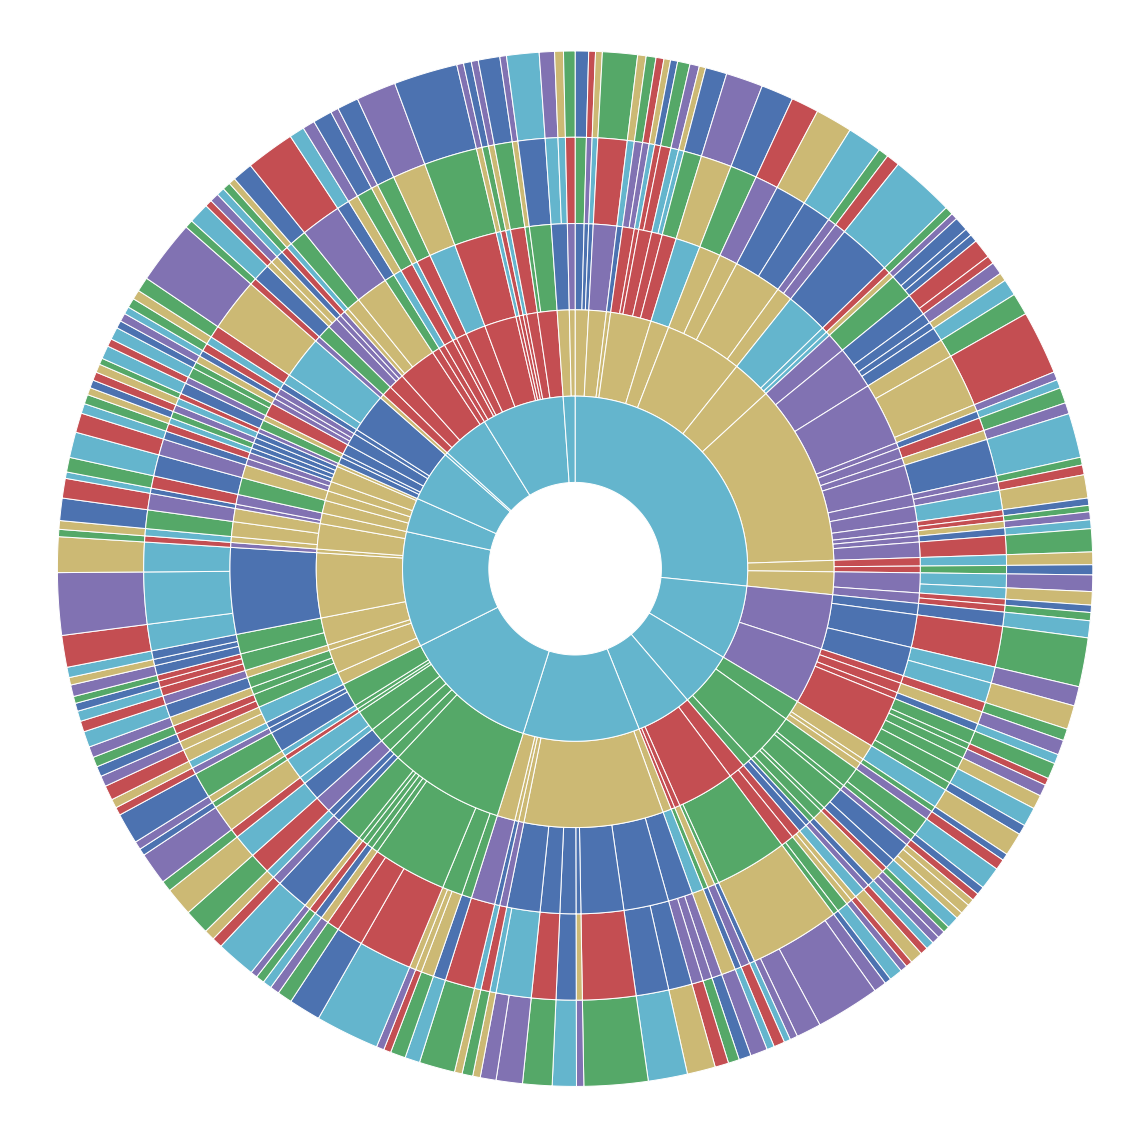

In [21]:
graph.sunburst(sunburst_data, figsize=(20, 20), showLabel=False)

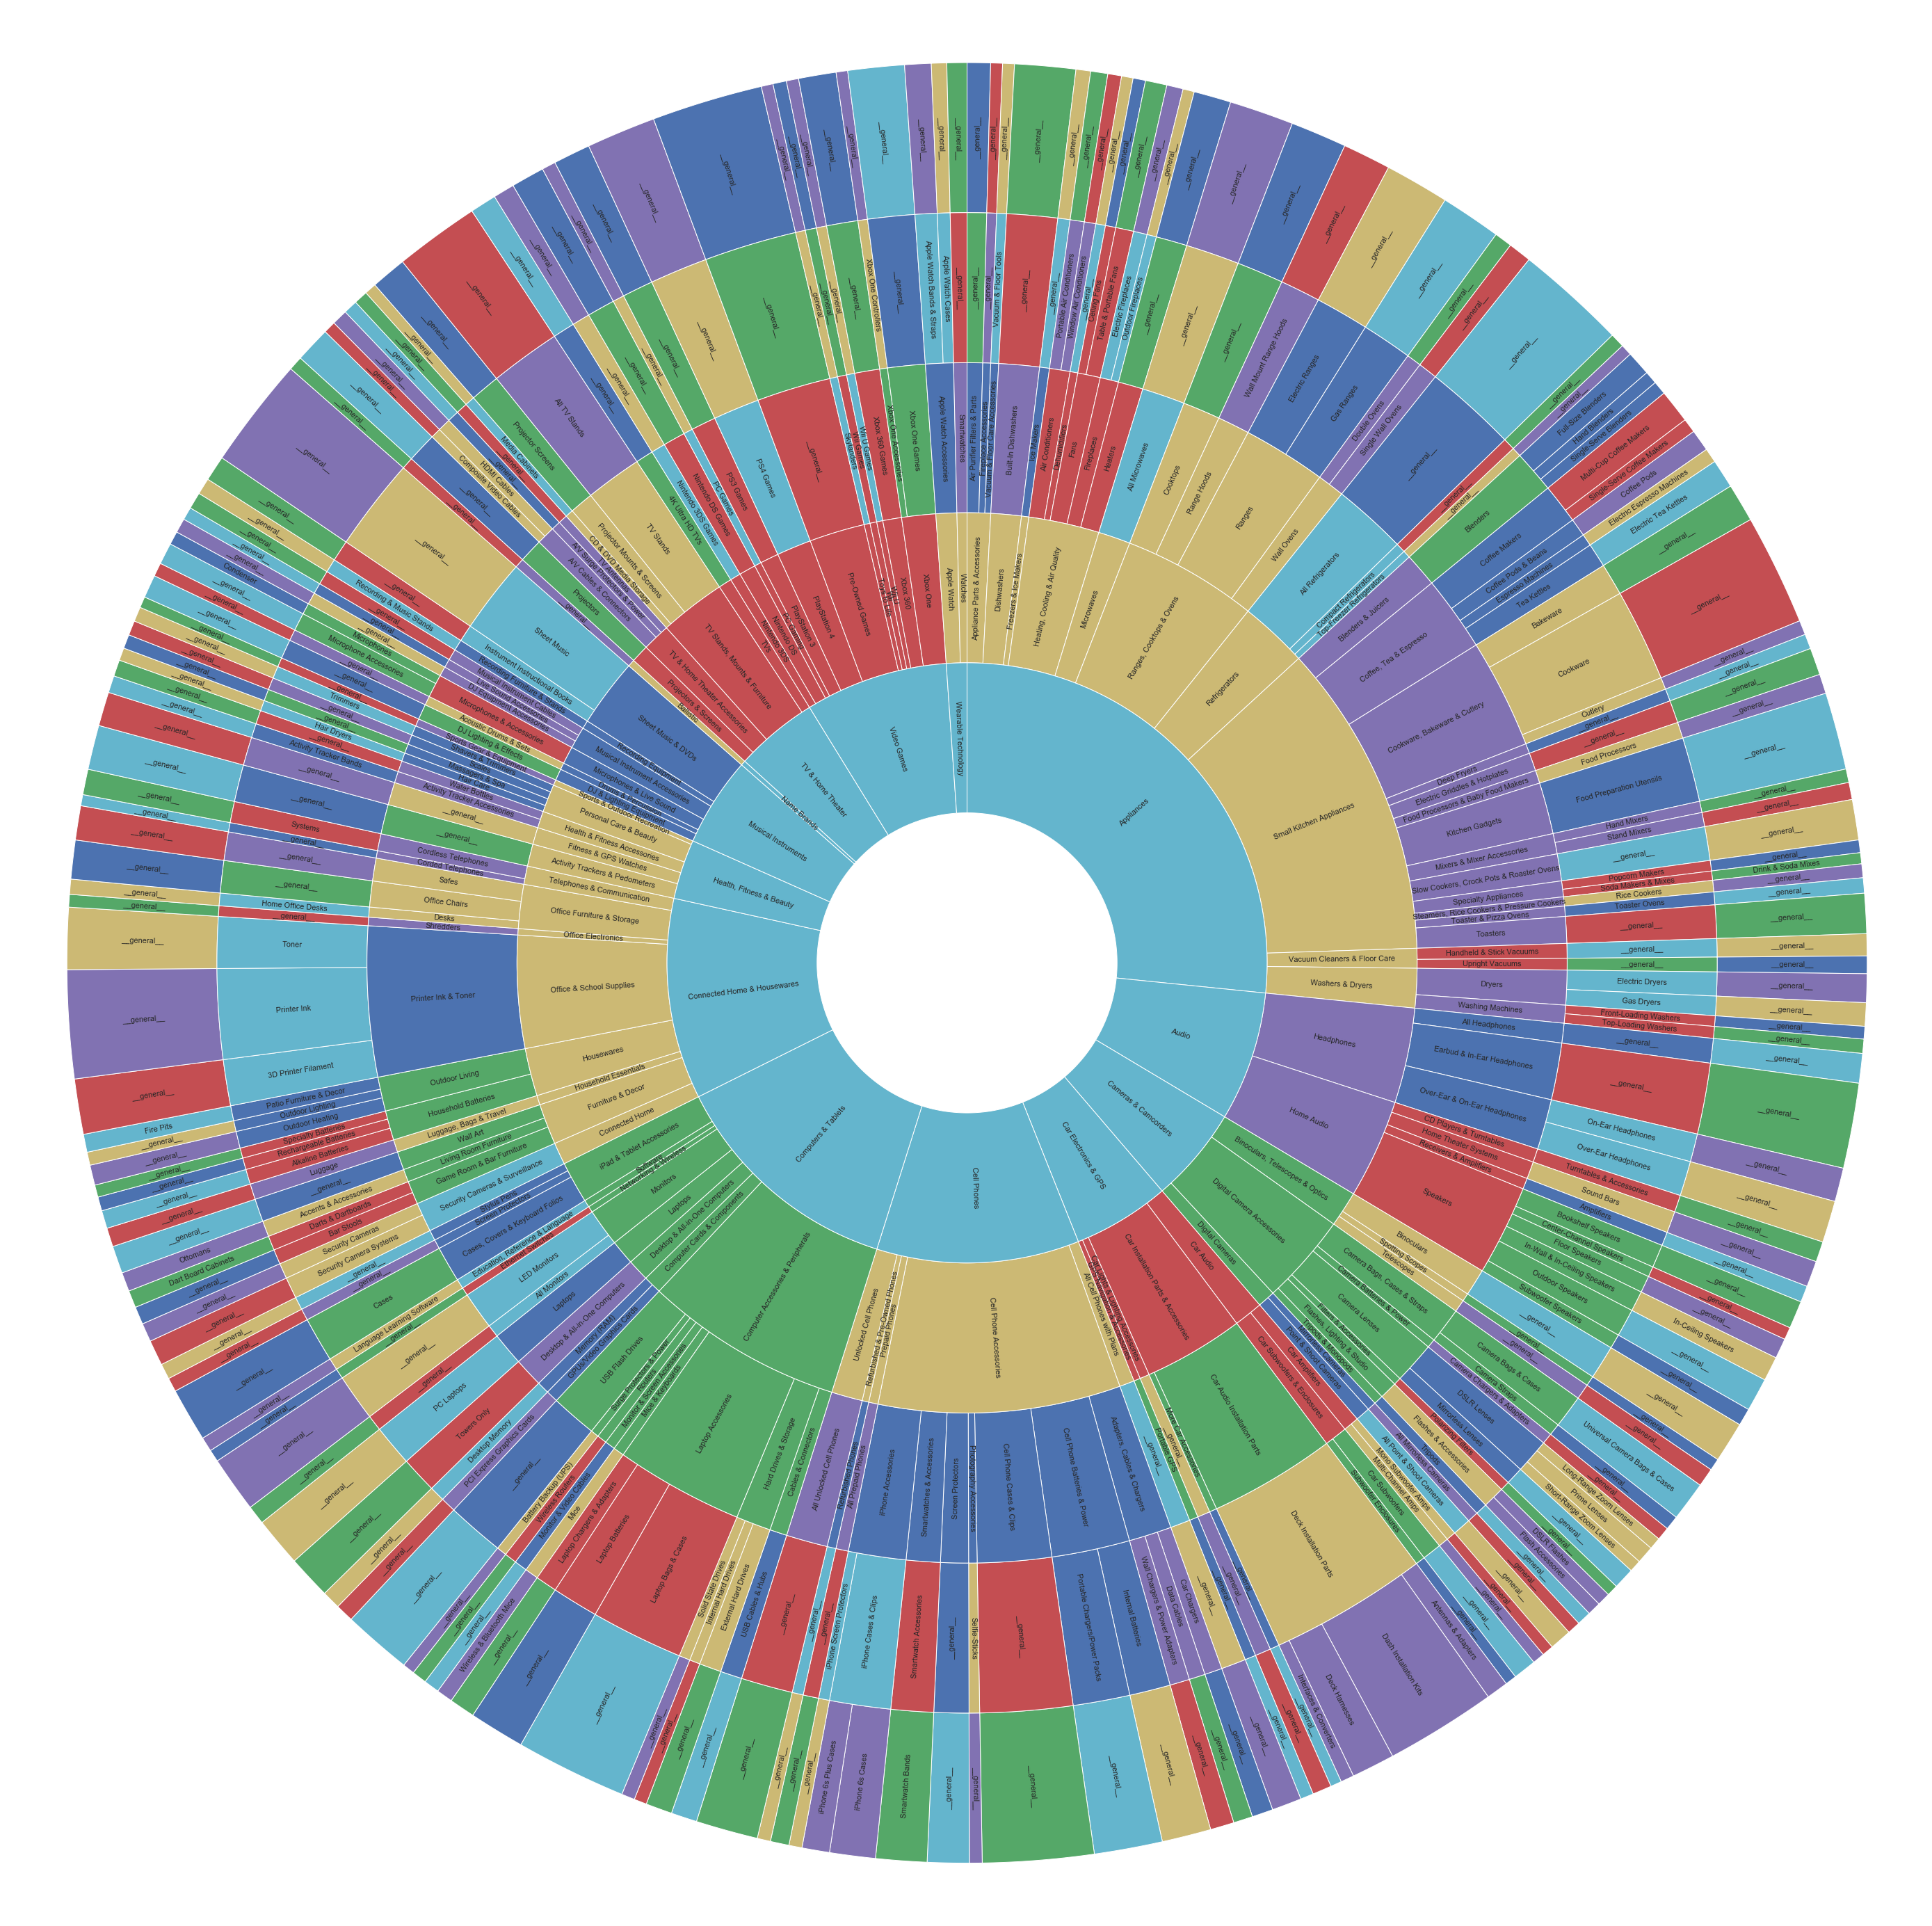

In [22]:
graph.sunburst(sunburst_data, figsize=(50, 50))

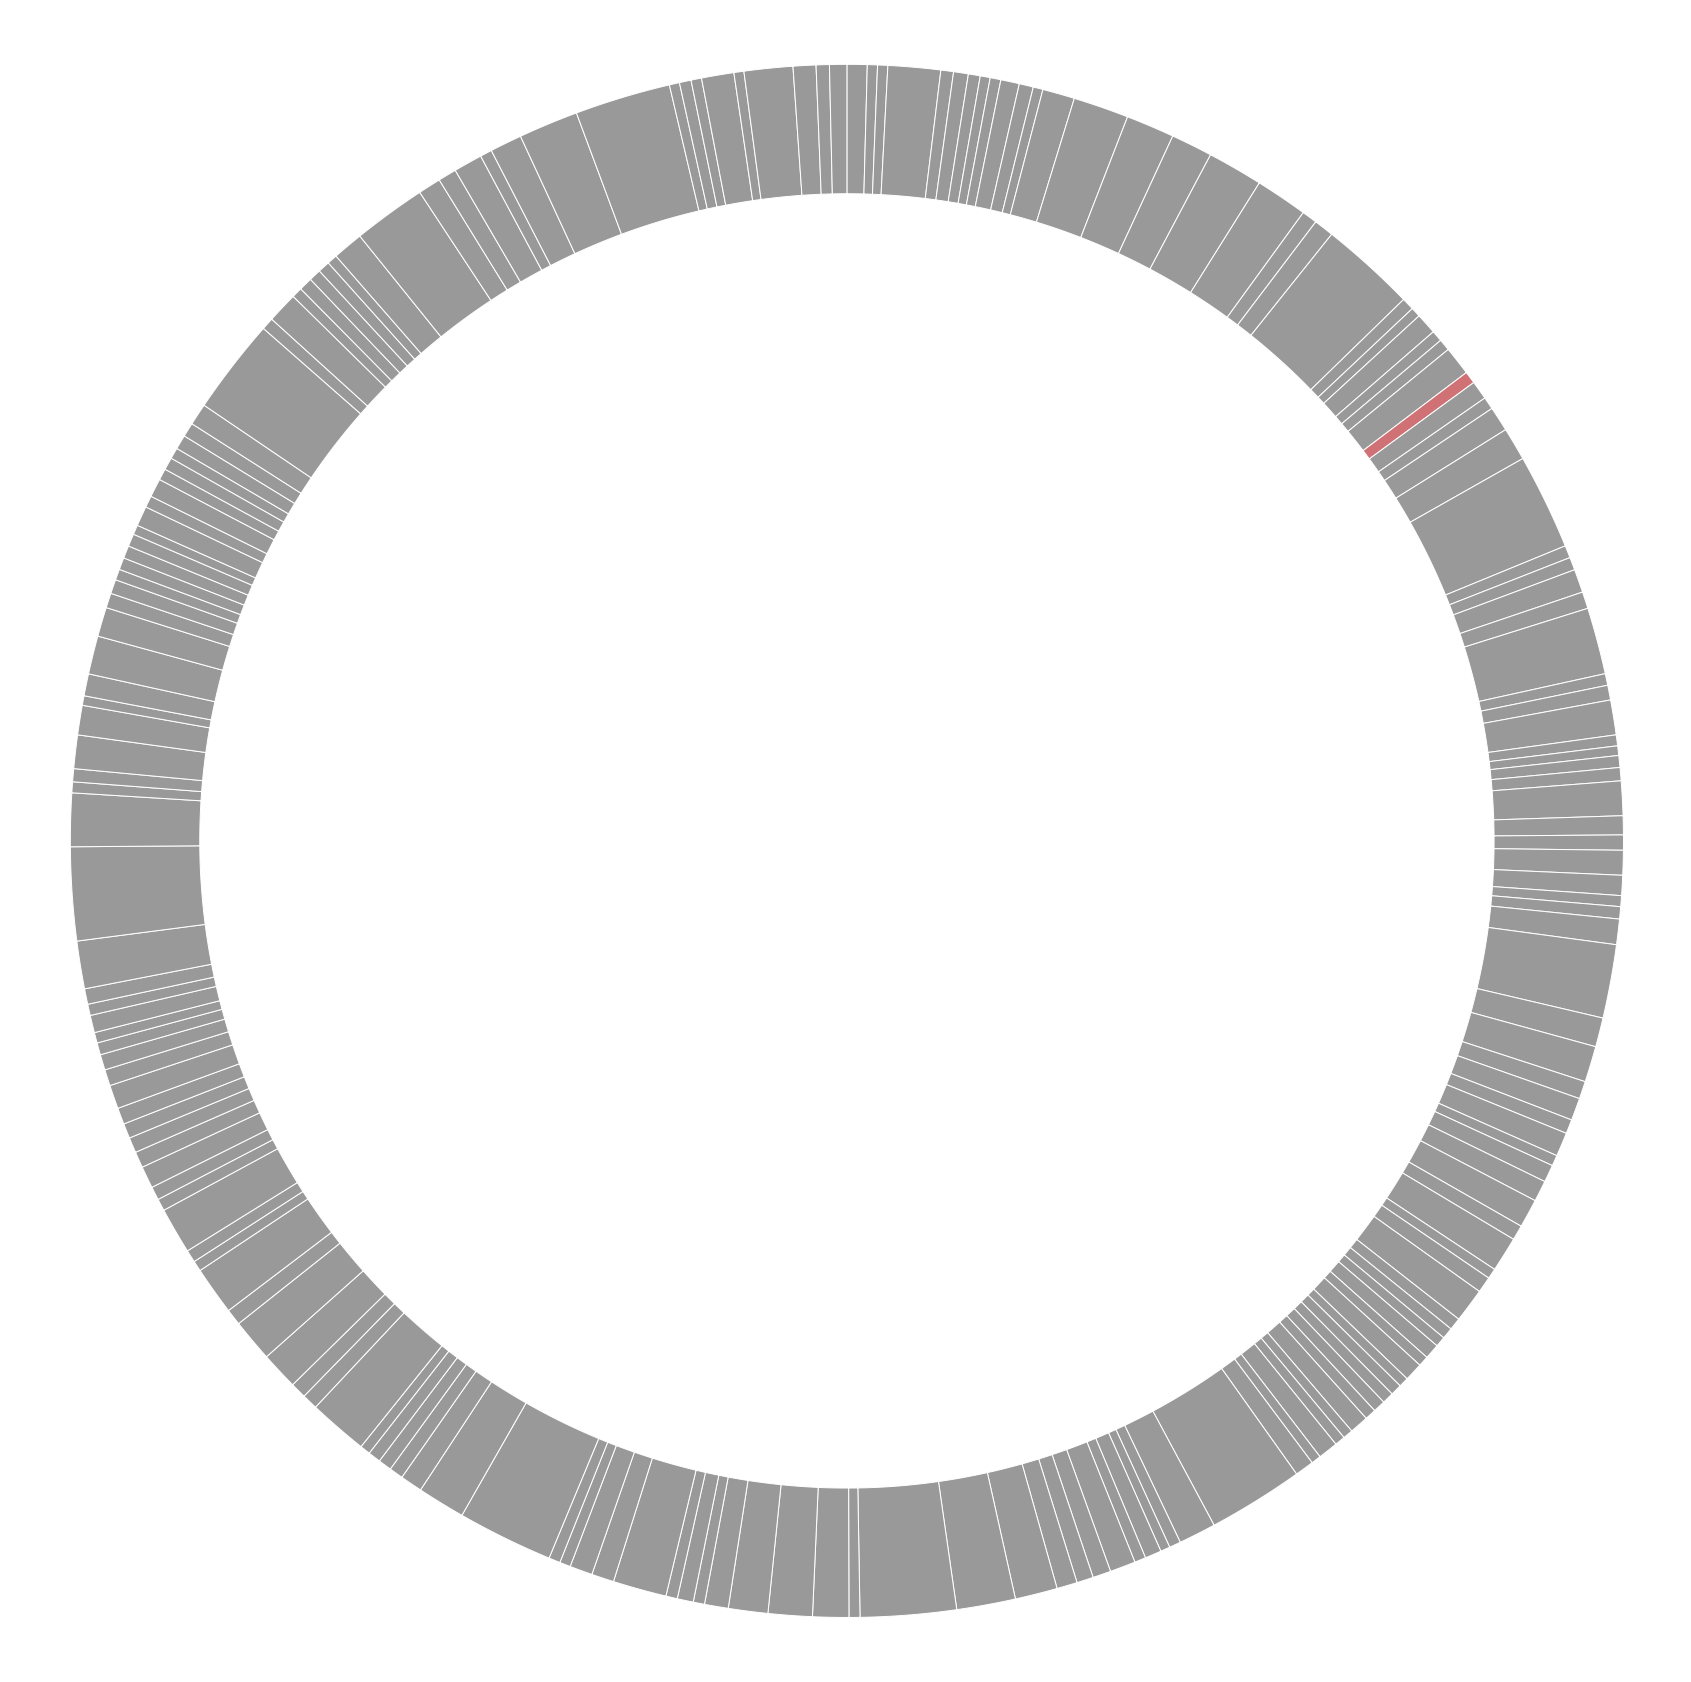

In [23]:
# point of view for a global classifier
graph.sunburst(sunburst_data, [0,1,2,3,4], ['','','','','Single-Serve Coffee Makers'], figsize=(30, 30), showLabel=False)

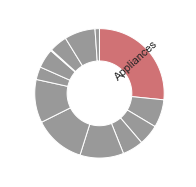

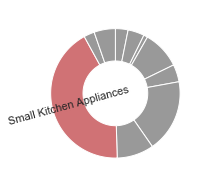

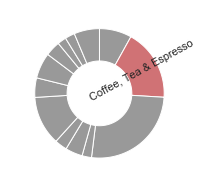

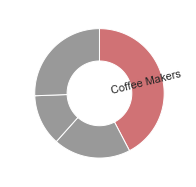

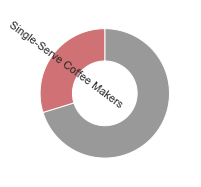

In [24]:
# point of view for a hierarquical classifier (multiple steps)
sunburst_data = graph.prepare_sunburst_data(processed_data, ['cat_1'])
graph.sunburst(sunburst_data, highlight_option=['Appliances'], figsize=(2.5,2.5))

sunburst_data = graph.prepare_sunburst_data(processed_data[processed_data['cat_1'] == 'Appliances'], ['cat_path_2'])
graph.sunburst(sunburst_data, highlight_option=['Small Kitchen Appliances'], figsize=(2.5,2.5))

sunburst_data = graph.prepare_sunburst_data(processed_data[processed_data['cat_path_2'] == 'Appliances::Small Kitchen Appliances'], ['cat_path_3'])
graph.sunburst(sunburst_data, highlight_option=['Coffee, Tea & Espresso'], figsize=(2.5,2.5))

sunburst_data = graph.prepare_sunburst_data(processed_data[processed_data['cat_path_3'] == 'Appliances::Small Kitchen Appliances::Coffee, Tea & Espresso'], ['cat_path_4'])
graph.sunburst(sunburst_data, highlight_option=['Coffee Makers'], figsize=(2.5,2.5))

sunburst_data = graph.prepare_sunburst_data(processed_data[processed_data['cat_path_4'] == 'Appliances::Small Kitchen Appliances::Coffee, Tea & Espresso::Coffee Makers'], ['cat_path_5'])
graph.sunburst(sunburst_data, highlight_option=['Single-Serve Coffee Makers'], figsize=(2.5,2.5))


In [25]:
# drop rows where name is null
processed_data = processed_data[pd.notnull(processed_data['name'])]

In [26]:
# aggregating all input text in one feature 
processed_data['all_text_features'] = processed_data.name.map(str) \
    + " " + processed_data.description.map(str) \
    + " " + processed_data.manufacturer.map(str)

In [27]:
processed_data.head()

name  \
0                Duracell - AAA Batteries (4-Pack)   
1  Duracell - AA 1.5V CopperTop Batteries (4-Pack)   
2                 Duracell - AA Batteries (8-Pack)   
3            Energizer - MAX Batteries AA (4-Pack)   
4                  Duracell - C Batteries (4-Pack)   

                                         description manufacturer  \
0  Compatible with select electronic devices; AAA...     Duracell   
1  Long-lasting energy; DURALOCK Power Preserve t...     Duracell   
2  Compatible with select electronic devices; AA ...     Duracell   
3  4-pack AA alkaline batteries; battery tester i...    Energizer   
4  Compatible with select electronic devices; C s...     Duracell   

                         cat_1       cat_2                cat_3  \
0  Connected Home & Housewares  Housewares  Household Batteries   
1  Connected Home & Housewares  Housewares  Household Batteries   
2  Connected Home & Housewares  Housewares  Household Batteries   
3  Connected Home & Housewares  Housewares  Household Batteries   
4  Connected Home & Housewares  Housewares  Household Batteries   

                cat_4        cat_5                   cat_path_1  \
0  Alkaline Batteries  __general__  Connected Home & Housewares   
1  Alkaline Batteries  __general__  Connected Home & Housewares   
2  Alkaline Batteries  __general__  Connected Home & Housewares   
3  Alkaline Batteries  __general__  Connected Home & Housewares   
4  Alkaline Batteries  __general__  Connected Home & Housewares   

                                cat_path_2  \
0  Connected Home & Housewares::Housewares   
1  Connected Home & Housewares::Housewares   
2  Connected Home & Housewares::Housewares   
3  Connected Home & Housewares::Housewares   
4  Connected Home & Housewares::Housewares   

                                          cat_path_3  \
0  Connected Home & Housewares::Housewares::House...   
1  Connected Home & Housewares::Housewares::House...   
2  Connected Home & Housewares::Housewares::House...   
3  Connected Home & Housewares::Housewares::House...   
4  Connected Home & Housewares::Housewares::House...   

                                          cat_path_4  \
0  Connected Home & Housewares::Housewares::House...   
1  Connected Home & Housewares::Housewares::House...   
2  Connected Home & Housewares::Housewares::House...   
3  Connected Home & Housewares::Housewares::House...   
4  Connected Home & Housewares::Housewares::House...   

                                          cat_path_5  \
0  Connected Home & Housewares::Housewares::House...   
1  Connected Home & Housewares::Housewares::House...   
2  Connected Home & Housewares::Housewares::House...   
3  Connected Home & Housewares::Housewares::House...   
4  Connected Home & Housewares::Housewares::House...   

                                   all_text_features  
0  Duracell - AAA Batteries (4-Pack) Compatible w...  
1  Duracell - AA 1.5V CopperTop Batteries (4-Pack...  
2  Duracell - AA Batteries (8-Pack) Compatible wi...  
3  Energizer - MAX Batteries AA (4-Pack) 4-pack A...  
4  Duracell - C Batteries (4-Pack) Compatible wit...

### Data split

In [28]:
# splitting data for trainning and test
# utilizing stratify due to unbalanced data
# X and y are not being separated here, because each method requires different attributes
X_train, X_test, y_train, y_test = train_test_split(
    processed_data, processed_data, test_size=.2, random_state=42, shuffle=True, stratify=processed_data['cat_path_5'])

### One level, flat trainning (for model selection)

In [29]:
# subsample for faster trainning
processed_sampled_data = X_train.sample(n=5000, random_state=42)
# reasuring category min size
processed_sampled_data = prunning_categories(processed_sampled_data, minimum_quantity_per_category, maximum_quantity_per_category, 'cat_path_5')
print(processed_sampled_data.shape)

Products before prunning: 5000
Categories before prunning: 197
Products after prunning: 1739
Categories after prunning: 24

(1739, 14)


In [30]:
# spliting features and labels
X_benchmark = processed_sampled_data['all_text_features']
y_benchmark = processed_sampled_data['cat_path_5']

In [31]:
# spliting train e test 
# stratify used because data is very unbalanced
X_benchmark_train, X_benchmark_test, y_benchmark_train, y_benchmark_test = train_test_split(
    X_benchmark, y_benchmark, test_size=.2, random_state=42, shuffle=True, stratify=y_benchmark)

In [51]:
def train(clf, X_train, y_train):
    
    start = time()
    clf.fit(X_train, y_train)
    end = time()

    print("Model trained in {:.4f} seconds".format(end - start))
    
    return clf

def predict(clf, X):

    start = time()
    y_pred = clf.predict(X)
    end = time()
    
    print("Predictions for {} samples made in {:.4f} seconds ({:.0f} pred/sec).".format(
        X.shape[0], end - start, X.shape[0]/(end - start)))
    
    return y_pred

def score(y, y_pred):
    #sample_accur = sum(y == y_pred)/y.shape[0]
    #print("Accuracy: {:.4f}.".format(sample_accur))
    sample_f1_score = f1_score(y, y_pred, average='weighted')
    print("F1 score: {:.4f}.".format(sample_f1_score))
    
    return sample_f1_score

def train_predict_score(clf, X_train, y_train, X_test, y_test):
    
    clf = train(clf, X_train, y_train)

    print('Predicting for training samples')
    y_train_pred = predict(clf, X_train)
    print('Scoring for training samples')
    score(y_train, y_train_pred)

    print('Predicting for testing samples')
    y_test_pred = predict(clf, X_test)
    print('Scoring for testing samples')
    score(y_test, y_test_pred)
    print('')



In [33]:
# classifiers being evaluated
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'SVC_linear': SVC(random_state=42, kernel="linear")
}

for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(encoding='utf-8', analyzer='word', lowercase=True, stop_words='english')),
        ('clf', classifier)])
    
    print('Training {} classifier.'.format(name))
    train_predict_score(pipeline, X_benchmark_train, y_benchmark_train, X_benchmark_test, y_benchmark_test)

Training MultinomialNB classifier.
Model trained in 0.1582 seconds
Predicting for training samples
Predictions for 1391 samples made in 0.1247 seconds (11151 pred/sec).
Scoring for training samples
F1 score: 0.9816.
Predicting for testing samples
Predictions for 348 samples made in 0.0296 seconds (11740 pred/sec).
Scoring for testing samples
F1 score: 0.9064.

Training LogisticRegression classifier.


C:\Users\rafael.zitto\AppData\Local\conda\conda\envs\Python3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model trained in 0.4202 seconds
Predicting for training samples
Predictions for 1391 samples made in 0.0681 seconds (20437 pred/sec).
Scoring for training samples
F1 score: 0.9942.
Predicting for testing samples
Predictions for 348 samples made in 0.0151 seconds (22973 pred/sec).
Scoring for testing samples
F1 score: 0.9764.

Training RandomForestClassifier classifier.
Model trained in 0.1911 seconds
Predicting for training samples
Predictions for 1391 samples made in 0.0693 seconds (20080 pred/sec).
Scoring for training samples
F1 score: 0.9993.
Predicting for testing samples
Predictions for 348 samples made in 0.0186 seconds (18723 pred/sec).
Scoring for testing samples
F1 score: 0.9598.

Training DecisionTreeClassifier classifier.
Model trained in 0.3010 seconds
Predicting for training samples
Predictions for 1391 samples made in 0.0831 seconds (16731 pred/sec).
Scoring for training samples
F1 score: 1.0000.
Predicting for testing samples
Predictions for 348 samples made in 0.0140 s

In [34]:
# tuning hyperparameters for SVC linear
parameters = {
        "clf__C": [1, 2, 4],
        "clf__tol": [0.0001, 0.001, 0.01]
    }

clf = Pipeline([
        ('tfidf', TfidfVectorizer(encoding='utf-8', analyzer='word', lowercase=True, stop_words='english')),
        ('clf', SVC(kernel='linear', random_state=42, probability=False))])

f1_scorer = make_scorer(f1_score, average='weighted')

cv_sets = StratifiedShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0).get_n_splits(X_benchmark_train, y_benchmark_train)

grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=f1_scorer, cv=cv_sets)

grid_obj = grid_obj.fit(X_benchmark_train, y_benchmark_train)

best_svc = grid_obj.best_estimator_

f1_score_svc = f1_score(y_benchmark_test, best_svc.predict(X_benchmark_test), average='weighted')
    
print("Tuned hyperparameters: {}".format(best_svc.get_params(deep=False)))
print("F1-score for tuned model: {:.4f}".format(f1_score_svc))

Tuned hyperparameters: {'memory': None, 'steps': [('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.0001, verbose=False))]}
F1-score for tuned model: 0.9828


In [35]:
# tuning hyperparameters for LogisticRegression
parameters = {
        "clf__class_weight" : [None, 'balanced'],
        "clf__penalty": ['l1','l2'],
        "clf__C": [1, 5, 10, 20],
        "clf__tol": [0.0001, 0.001, 0.01]
    }

clf = Pipeline([
        ('tfidf', TfidfVectorizer(encoding='utf-8', analyzer='word', lowercase=True, stop_words='english')),
        ('clf', LogisticRegression(random_state=42, max_iter=4000))])

f1_scorer = make_scorer(f1_score, average='weighted')

cv_sets = StratifiedShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0).get_n_splits(X_benchmark_train, y_benchmark_train)

grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=f1_scorer, cv=cv_sets)

grid_obj = grid_obj.fit(X_benchmark_train, y_benchmark_train)

best_logistic_reg = grid_obj.best_estimator_

f1_score_logistic_reg = f1_score(y_benchmark_test, best_logistic_reg.predict(X_benchmark_test), average='weighted')
    
print("Tuned hyperparameters: {}".format(best_logistic_reg.get_params(deep=False)))
print("F1-score for tuned model: {:.4f}".format(f1_score_logistic_reg))

Tuned hyperparameters: {'memory': None, 'steps': [('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]}
F1-score for tuned model: 0.9883


In [36]:
best_classif = clone(best_logistic_reg)

### All levels, flat trainning

In [37]:
#spliting data
X_flat_train = X_train['all_text_features']
y_flat_train = y_train['cat_path_5']
X_flat_test = X_test['all_text_features']
y_flat_test = y_test['cat_path_5']

In [38]:
# train, predict and score
train_predict_score(best_classif, X_flat_train, y_flat_train, X_flat_test, y_flat_test)

Model trained in 56.3993 seconds
Predicting for training samples
Predictions for 20092 samples made in 1.1107 seconds (18090 pred/sec).
Scoring for training samples
F1 score: 0.9804.
Predicting for testing samples
Predictions for 5023 samples made in 0.2629 seconds (19110 pred/sec).
Scoring for testing samples
F1 score: 0.9279.



### All levels, hierarquical trainning

In [39]:
#spliting data
X_hier_train = X_train['all_text_features']
y_hier_train = y_train[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5']]
y_hier_train_path = y_train[['cat_path_5']]
X_hier_test = X_test['all_text_features']
y_hier_test_path = y_test[['cat_path_5']]

In [40]:
# train, predict and score for hierarchical
def train_predict_score_hier(clf, X_train, y_train, y_train_path, X_test, y_test_path):
    
    clfHqc = HierarchicalClassifier(clf)

    clfHqc = train(clfHqc, X_train, y_train)

    print('Predicting for training samples')
    y_train_pred = predict(clfHqc, X_train)
    print('Scoring for training samples')
    score(y_train_path, y_train_pred)

    print('Predicting for testing samples')
    y_test_pred = predict(clfHqc, X_test)
    print('Scoring for testing samples')
    score(y_test_path, y_test_pred)
    print('')
    return clfHqc

In [41]:
clfHqc = train_predict_score_hier(best_classif, X_hier_train, y_hier_train, y_hier_train_path, X_hier_test, y_hier_test_path)

fiting branch ['root']
fiting branch ['root', 'Audio']
fiting branch ['root', 'Audio', 'Home Audio']
fiting branch ['root', 'Audio', 'Home Audio', 'Receivers & Amplifiers']
fiting branch ['root', 'Audio', 'Home Audio', 'Receivers & Amplifiers', 'Amplifiers']
fiting branch ['root', 'Audio', 'Home Audio', 'Home Theater Systems']
fiting branch ['root', 'Audio', 'Home Audio', 'Home Theater Systems', 'Sound Bars']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers', 'In-Wall & In-Ceiling Speakers']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers', 'Bookshelf Speakers']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers', 'Center-Channel Speakers']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers', 'Outdoor Speakers']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers', 'Subwoofer Speakers']
fiting branch ['root', 'Audio', 'Home Audio', 'Speakers', 'Floor Speakers']
fiting branch ['root', 'Audio', 'Home A

fiting branch ['root', 'Health, Fitness & Beauty', 'Personal Care & Beauty', 'Massagers & Spa']
fiting branch ['root', 'Health, Fitness & Beauty', 'Personal Care & Beauty', 'Massagers & Spa', '__general__']
fiting branch ['root', 'Health, Fitness & Beauty', 'Sports & Outdoor Recreation']
fiting branch ['root', 'Health, Fitness & Beauty', 'Sports & Outdoor Recreation', 'Sports Gear & Equipment']
fiting branch ['root', 'Health, Fitness & Beauty', 'Sports & Outdoor Recreation', 'Sports Gear & Equipment', '__general__']
fiting branch ['root', 'Computers & Tablets']
fiting branch ['root', 'Computers & Tablets', 'iPad & Tablet Accessories']
fiting branch ['root', 'Computers & Tablets', 'iPad & Tablet Accessories', 'Cases, Covers & Keyboard Folios']
fiting branch ['root', 'Computers & Tablets', 'iPad & Tablet Accessories', 'Cases, Covers & Keyboard Folios', 'Cases']
fiting branch ['root', 'Computers & Tablets', 'iPad & Tablet Accessories', 'Stylus Pens']
fiting branch ['root', 'Computers & Ta

fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Blenders & Juicers', 'Blenders']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Specialty Appliances']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Specialty Appliances', 'Popcorn Makers']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Specialty Appliances', 'Soda Makers & Mixes']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Toasters']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Toasters', '__general__']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Kitchen Gadgets']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Kitchen Gadgets', 'Food Preparation Utensils']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Toaster & Pizza Ovens']
fiting branch ['root', 'Appliances', 'Small Kitchen Appliances', 'Toaster & Pizza Ovens', 'Toaster Ovens']
fiting branch ['root', 'Applia

fiting branch ['root', 'Connected Home & Housewares', 'Office & School Supplies']
fiting branch ['root', 'Connected Home & Housewares', 'Office & School Supplies', 'Printer Ink & Toner']
fiting branch ['root', 'Connected Home & Housewares', 'Office & School Supplies', 'Printer Ink & Toner', 'Toner']
fiting branch ['root', 'Connected Home & Housewares', 'Office & School Supplies', 'Printer Ink & Toner', '3D Printer Filament']
fiting branch ['root', 'Connected Home & Housewares', 'Office & School Supplies', 'Printer Ink & Toner', 'Printer Ink']
fiting branch ['root', 'Connected Home & Housewares', 'Connected Home']
fiting branch ['root', 'Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance']
fiting branch ['root', 'Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Cameras']
fiting branch ['root', 'Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera Systems']
fiting bran

fiting branch ['root', 'Wearable Technology', 'Apple Watch', 'Apple Watch Accessories', 'Apple Watch Cases']
fiting branch ['root', 'Wearable Technology', 'Apple Watch', 'Apple Watch Accessories', 'Apple Watch Bands & Straps']
fiting branch ['root', 'Wearable Technology', 'Watches']
fiting branch ['root', 'Wearable Technology', 'Watches', 'Smartwatches']
fiting branch ['root', 'Wearable Technology', 'Watches', 'Smartwatches', '__general__']
fiting branch ['root', 'Name Brands']
fiting branch ['root', 'Name Brands', 'Ballistic']
fiting branch ['root', 'Name Brands', 'Ballistic', '__general__']
fiting branch ['root', 'Name Brands', 'Ballistic', '__general__', '__general__']
Model trained in 10.2195 seconds
Predicting for training samples
Predictions for 20092 samples made in 49.6679 seconds (405 pred/sec).
Scoring for training samples


C:\Users\rafael.zitto\AppData\Local\conda\conda\envs\Python3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 score: 0.9835.
Predicting for testing samples
Predictions for 5023 samples made in 12.7334 seconds (394 pred/sec).
Scoring for testing samples
F1 score: 0.9267.



In [42]:
test_pred = clfHqc.predict(X_hier_test)

In [43]:
test_pred_proba = clfHqc.predict_proba(X_hier_test)

In [44]:
# calculating score by level
f1_score_per_level = {'level':[], 'score':[]}
for i in range(1, 6):
    test_level_pred = list(map(lambda x: '::'.join(x.split('::')[0:i]), test_pred))
    level_score = f1_score(processed_data.loc[X_hier_test.index]['cat_path_' + str(i)], 
             test_level_pred, average='weighted')
    f1_score_per_level['level'].append(i)
    f1_score_per_level['score'].append(level_score)
    print("F1-score for test data (level {}): {:.4f}.".format(i, level_score))

F1-score for test data (level 1): 0.9875.
F1-score for test data (level 2): 0.9697.
F1-score for test data (level 3): 0.9443.
F1-score for test data (level 4): 0.9318.


C:\Users\rafael.zitto\AppData\Local\conda\conda\envs\Python3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1-score for test data (level 5): 0.9267.


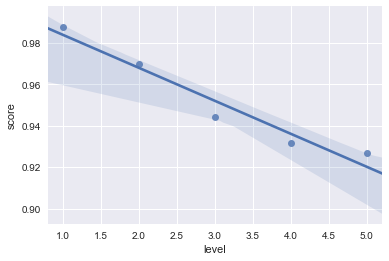

In [45]:
# plotting
pred_df = pd.DataFrame(f1_score_per_level)
sns.regplot('level', 'score', pred_df)

In [46]:
# precision
sum(processed_data.loc[X_hier_test.index]['cat_path_5'] == clfHqc.predict(X_hier_test))/X_hier_test.shape[0]

0.9219589886521998

In [53]:
# checking robustness form flat classifier
import math
import random

def reduceText(text):
    words = text.split(' ')
    num_to_del = math.ceil(len(words)/10)
    for i in range(0, num_to_del):
        idx = random.randint(0, len(words) - 1)
        del words[idx]
    new_text = " ".join(words)
    return new_text

#spliting data
X_flat_train = X_train['all_text_features'].apply(reduceText)
y_flat_train = y_train['cat_path_5']
X_flat_test = X_test['all_text_features'].apply(reduceText)
y_flat_test = y_test['cat_path_5']

train_predict_score(best_classif, X_flat_train, y_flat_train, X_flat_test, y_flat_test)

Model trained in 50.3513 seconds
Predicting for training samples
Predictions for 20092 samples made in 0.9645 seconds (20832 pred/sec).
Scoring for training samples
F1 score: 0.9785.
Predicting for testing samples
Predictions for 5023 samples made in 0.3032 seconds (16566 pred/sec).
Scoring for testing samples
F1 score: 0.9120.

